In [69]:
# !pip install gym stable-baselines3 gym-anytrading
# pip install stable_baselines

In [9]:
import gym
import gym_anytrading

from finta import TA

from stable_baselines3.common.vec_env import DummyVecEnv
from gym_anytrading.envs import ForexEnv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from stable_baselines3 import PPO,A2C

In [10]:
df = pd.read_csv("EURUSD_M1_202411201555_202412311327.csv",delimiter='\t')
df['Datetime'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])
df = df.drop(columns=['<VOL>', '<DATE>', '<TIME>'])
df.set_index('Datetime',inplace=True)


df.rename(columns={
    '<CLOSE>': 'Close',
    '<OPEN>': 'Open',
    '<HIGH>': 'High',
    '<LOW>': 'Low',
    '<TICKVOL>': 'Volume',
    '<SPREAD>': 'Spread'
}, inplace=True)

df['SMA'] = TA.SMA(df,12)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df.fillna(0,inplace=True)

df.dtypes


Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
Spread      int64
SMA       float64
RSI       float64
OBV       float64
dtype: object

In [11]:
df

,Open,High,Low,Close,Volume,Spread,SMA,RSI,OBV
Datetime,,,,,,,,,
2024-11-20 15:55:00,1.05566,1.05568,1.05554,1.05560,33,4,0.000000,0.000000,0.0
2024-11-20 15:56:00,1.05559,1.05562,1.05549,1.05554,37,4,0.000000,0.000000,-37.0
2024-11-20 15:57:00,1.05554,1.05567,1.05554,1.05560,38,4,0.000000,51.851852,1.0
2024-11-20 15:58:00,1.05562,1.05566,1.05556,1.05558,44,4,0.000000,43.714972,-43.0
2024-11-20 15:59:00,1.05559,1.05566,1.05554,1.05565,36,4,0.000000,64.633722,-7.0
...,...,...,...,...,...,...,...,...,...
2024-12-31 13:23:00,1.04168,1.04169,1.04158,1.04159,24,4,1.041712,48.758244,1788.0
2024-12-31 13:24:00,1.04159,1.04159,1.04146,1.04147,19,4,1.041697,43.954507,1769.0
2024-12-31 13:25:00,1.04147,1.04163,1.04146,1.04161,21,4,1.041688,50.127854,1790.0


In [4]:
def add_signal(env):
    start = env.frame_bound[0]-env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:,'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:,['Open','High','Low','Close','Volume','Spread','SMA','RSI','OBV']].to_numpy()[start:end]
    return prices,signal_features

In [5]:
class MyCustomEnv(ForexEnv):
    _process_data = add_signal

env2 = MyCustomEnv(df=df, frame_bound=(12, 80000), window_size=12)

In [6]:
env = ForexEnv(df=df, frame_bound=(5, 100), window_size=5)

In [7]:
env.action_space

Discrete(2)

info {'total_reward': 26.90434455871582, 'total_profit': 0.9968248748269026, 'position': <Positions.Short: 0>}


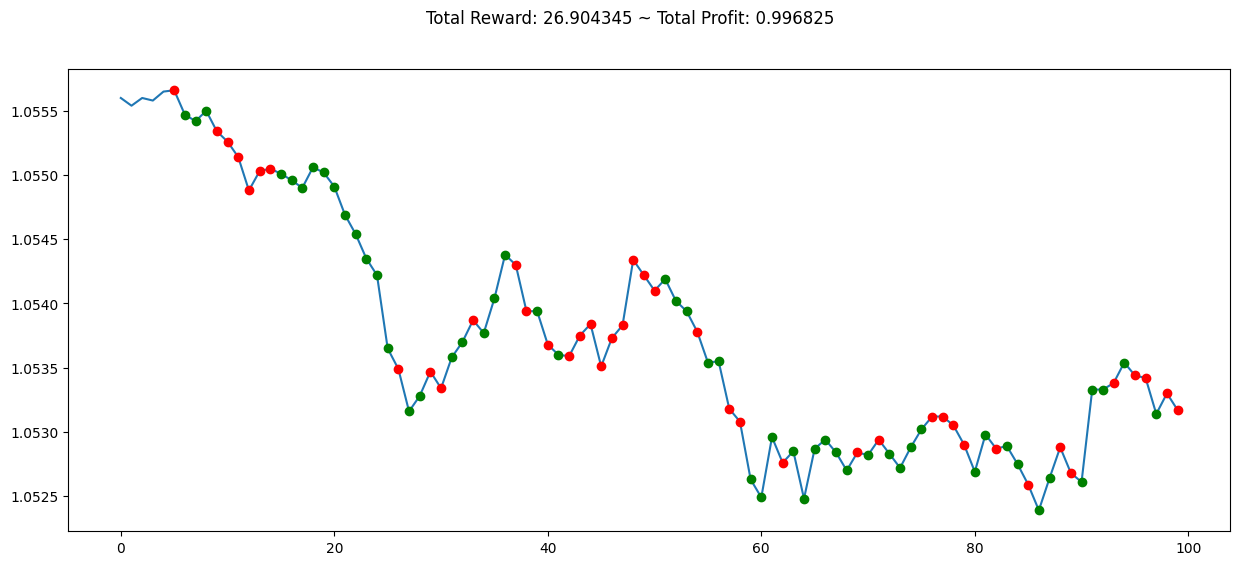

In [8]:
state = env.reset()

while True:
    action = env.action_space.sample()
    n_state, reward, done, _, info = env.step(action)
    if _:
        print("info", info)
        break

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [9]:

env_maker = lambda: env2
env= DummyVecEnv([env_maker])

In [11]:
model = A2C('MlpPolicy',env,verbose=1)
model.learn(total_timesteps=100000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| time/                 |          |
|    fps                | 325      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.687   |
|    explained_variance | 0.0103   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.356   |
|    value_loss         | 1.31     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 999      |
|    ep_rew_mean        | -10.6    |
| time/                 |          |
|    fps                | 370      |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss 

In [12]:
print(env.action_space)

Discrete(2)


info {'total_reward': 31.200000000046746, 'total_profit': 0.9797439050301736, 'position': <Positions.Long: 1>}


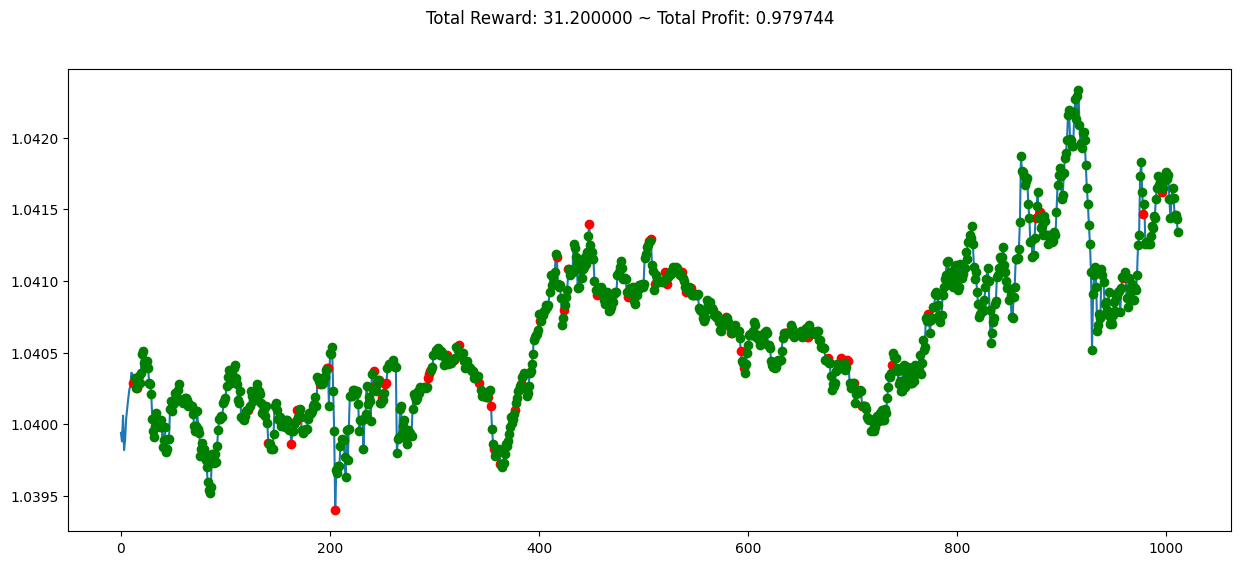

In [13]:
env = MyCustomEnv(df=df, frame_bound=(39156, 40156), window_size=12)
obs, _ = env.reset()

while True:
    action, _states = model.predict(obs)
    
    obs, reward, done, _, info = env.step(action)
    
    if _:
        print("info", info)
        break

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [12]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt

class TRYForexEnv(gym.Env):
    def __init__(self, df, window_size):
        super(TRYForexEnv, self).__init__()
        self.df = df
        self.window_size = window_size
        self.current_step = window_size
        self.balance = 1000  # Initial balance
        self.position = None  # None, "buy", "sell"
        self.entry_price = 0
        self.volume = 0  # New attribute to track volume
        self.trades = []

        # Action space: 0 = open buy, 1 = open sell, 2 = close buy, 3 = close sell, 4 = hold
        self.action_space = spaces.Discrete(5)

        # Observation space: [price data + indicators]
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(window_size, len(df.columns)), dtype=np.float32
        )

    def reset(self):
        self.current_step = self.window_size
        self.balance = 1000
        self.position = None
        self.entry_price = 0
        self.volume = 0
        self.trades = []
        return self._get_observation()

    def step(self, action):
        done = False
        reward = 0
        current_price = self.df['Close'].iloc[self.current_step]

        if action == 0:  # Open Buy
            if self.position is None:
                self.position = "buy"
                self.entry_price = current_price
                self.volume = 1  # Start with 1 unit
                self.trades.append((self.current_step, "buy", current_price))
                print('เปิด buy 1 volume, ที่ราคา',current_price)
            elif self.position == "buy":
                # Add volume to existing buy position
                self.volume += 1
                self.entry_price = ((self.entry_price * (self.volume - 1)) + current_price) / self.volume
                self.trades.append((self.current_step, "buy", current_price))
                print('ซื้อ buy เพิ่ม เป็น',self.volume,' volume, ที่ราคา',current_price,'เฉลี่ย = ',self.entry_price)
                
            else:
                reward = -1
                #ลงโทษสำหรับ buy -> sell (ต้องปิดก่อน)
                
        elif action == 1:  # Open Sell
            if self.position is None:
                self.position = "sell"
                self.entry_price = current_price
                self.volume = 1  # Start with 1 unit
                self.trades.append((self.current_step, "sell", current_price))
                print('เปิด sell 1 volume, ที่ราคา',current_price)
            elif self.position == "sell":
                # Add volume to existing sell position
                self.volume += 1
                self.entry_price = ((self.entry_price * (self.volume - 1)) + current_price) / self.volume
                self.trades.append((self.current_step, "sell", current_price))
                print('ซื้อ sell เพิ่ม เป็น',self.volume,' volume, ที่ราคา',current_price,'เฉลี่ย = ',self.entry_price)
                
            else:
                reward = -1
                #ลงโทษสำหรับ sell -> buy (ต้องปิดก่อน)

        elif action == 2:  # Close Buy
            if self.position == "buy":
                reward = (current_price - self.entry_price) * self.volume
                self.balance += reward
                self.trades.append((self.current_step, "close_buy", current_price))
                print("ปิด buy ที่ราคา",current_price,"จำนวน",self.volume,"ได้กำไร",reward)
                print("----------------------")
                self.position = None
                self.volume = 0

        elif action == 3:  # Close Sell
            if self.position == "sell":
                reward = (self.entry_price - current_price) * self.volume
                self.balance += reward
                self.trades.append((self.current_step, "close_sell", current_price))
                print("ปิด sell ที่ราคา",current_price,"จำนวน",self.volume,"ได้กำไร",reward)
                print("----------------------")
                self.position = None
                self.volume = 0

        elif action == 4:  # Hold
            # No changes to position or balance, simply hold
            reward = -0.1

        # Update to next step
        self.current_step += 1
        if self.current_step >= len(self.df) - 1:
            done = True

        obs = self._get_observation()
        info = {"balance": self.balance, "volume": self.volume}
        return obs, reward, done, info

    def _get_observation(self):
        return self.df.iloc[self.current_step - self.window_size:self.current_step].values

    def render(self):
        print(f"Step: {self.current_step}, Balance: {self.balance}, Position: {self.position}, Volume: {self.volume}")

    def plot_trades(self):
        plt.figure(figsize=(15, 6))
        plt.plot(self.df.index, self.df['Close'], label='Close Price', color='blue')

        for step, action, price in self.trades:
            if action == "buy":
                plt.scatter(self.df.index[step], price, color='green', label='Buy', marker='^')
            elif action == "sell":
                plt.scatter(self.df.index[step], price, color='pink', label='Sell', marker='v')
            elif action == "close_buy":
                plt.scatter(self.df.index[step], price, color='red', label='Close Buy', marker='o')
            elif action == "close_sell":
                plt.scatter(self.df.index[step], price, color='orange', label='Close Sell', marker='o')

        # Adjust axes for better visualization
        plt.xlim(self.df.index[0], self.df.index[-1])
        plt.ylim(self.df['Close'].min() * 0.95, self.df['Close'].max() * 1.05)

        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), loc="upper left")

        plt.title("Forex Trading Actions")
        plt.xlabel("Time Steps")
        plt.ylabel("Price")
        plt.grid()
        plt.show()

เปิด sell 1 volume, ที่ราคา 1.05488
ซื้อ sell เพิ่ม เป็น 2  volume, ที่ราคา 1.05501 เฉลี่ย =  1.054945
ซื้อ sell เพิ่ม เป็น 3  volume, ที่ราคา 1.0549 เฉลี่ย =  1.05493
ปิด sell ที่ราคา 1.05502 จำนวน 3 ได้กำไร -0.00027000000000043656
----------------------
เปิด sell 1 volume, ที่ราคา 1.05491
ปิด sell ที่ราคา 1.05365 จำนวน 1 ได้กำไร 0.0012600000000000389
----------------------
เปิด buy 1 volume, ที่ราคา 1.05316
ซื้อ buy เพิ่ม เป็น 2  volume, ที่ราคา 1.05347 เฉลี่ย =  1.053315
ปิด buy ที่ราคา 1.0537 จำนวน 2 ได้กำไร 0.0007700000000001594
----------------------
เปิด buy 1 volume, ที่ราคา 1.05377
ซื้อ buy เพิ่ม เป็น 2  volume, ที่ราคา 1.05438 เฉลี่ย =  1.054075
ซื้อ buy เพิ่ม เป็น 3  volume, ที่ราคา 1.0543 เฉลี่ย =  1.0541500000000001
ซื้อ buy เพิ่ม เป็น 4  volume, ที่ราคา 1.05394 เฉลี่ย =  1.0540975000000001
ปิด buy ที่ราคา 1.05368 จำนวน 4 ได้กำไร -0.0016700000000007265
----------------------
เปิด sell 1 volume, ที่ราคา 1.05383
ซื้อ sell เพิ่ม เป็น 2  volume, ที่ราคา 1.05419 เฉลี่ย =  1.054

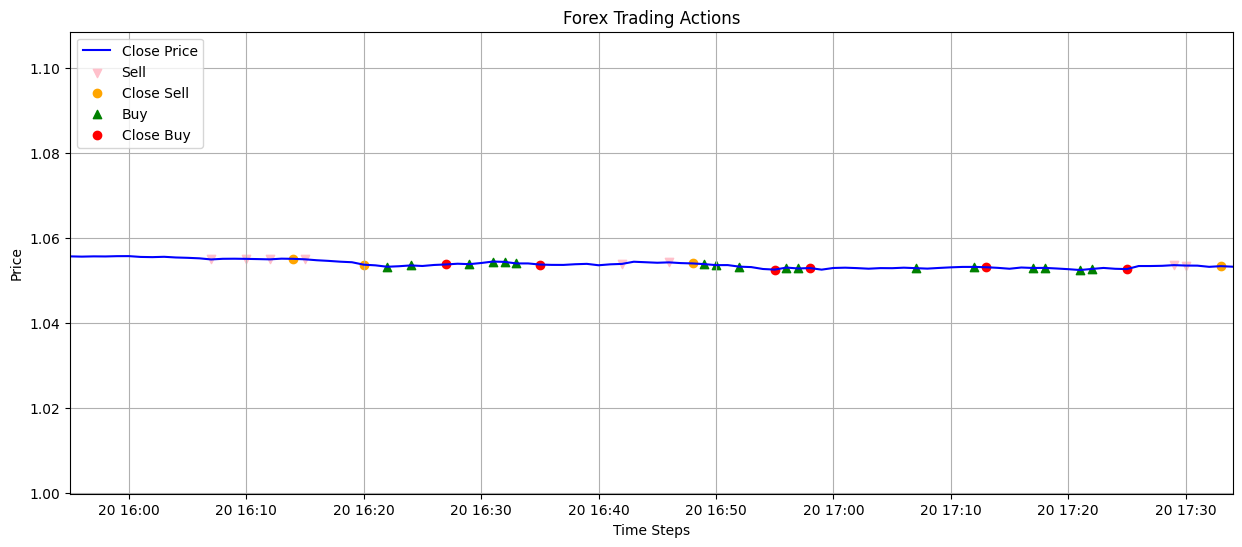

In [13]:
env = TRYForexEnv(df=df[:100], window_size=12)
obs = env.reset()

done = False
while not done:
    action = env.action_space.sample()  # Random action
    obs, reward, done, info = env.step(action)
env.plot_trades()

In [14]:
env_maker = lambda: TRYForexEnv(df=df[:5000], window_size=12)
env4= DummyVecEnv([env_maker])

C:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [15]:
from stable_baselines3.common.callbacks import EvalCallback


eval_callback = EvalCallback(
    env4,  # Environment สำหรับการประเมินผล
    best_model_save_path='./best_model/',  # ที่เก็บโมเดลที่ดีที่สุด
    log_path='./logs/',  # ที่เก็บ logs
    eval_freq=1000,  # ความถี่ในการประเมินผล
    deterministic=True,  # ใช้ deterministic policy
    render=False,  # ไม่ต้องแสดงการแสดงผล
)

# สร้าง PPO model
model = PPO('MlpPolicy', env4, verbose=1)

# เรียนรู้โดยใช้ eval_callback
model.learn(total_timesteps=10000, callback=eval_callback)

Using cpu device
เปิด buy 1 volume, ที่ราคา 1.05505
ซื้อ buy เพิ่ม เป็น 2  volume, ที่ราคา 1.05496 เฉลี่ย =  1.055005
ปิด buy ที่ราคา 1.0549 จำนวน 2 ได้กำไร -0.00021000000000004349
----------------------
เปิด buy 1 volume, ที่ราคา 1.05454
ซื้อ buy เพิ่ม เป็น 2  volume, ที่ราคา 1.05435 เฉลี่ย =  1.0544449999999999
ปิด buy ที่ราคา 1.05422 จำนวน 2 ได้กำไร -0.0004499999999998394
----------------------
เปิด buy 1 volume, ที่ราคา 1.05365
ปิด buy ที่ราคา 1.05349 จำนวน 1 ได้กำไร -0.00015999999999993797
----------------------
เปิด sell 1 volume, ที่ราคา 1.05328
ซื้อ sell เพิ่ม เป็น 2  volume, ที่ราคา 1.0537 เฉลี่ย =  1.05349
ปิด sell ที่ราคา 1.05377 จำนวน 2 ได้กำไร -0.000560000000000116
----------------------
เปิด buy 1 volume, ที่ราคา 1.05404
ซื้อ buy เพิ่ม เป็น 2  volume, ที่ราคา 1.05438 เฉลี่ย =  1.05421
ซื้อ buy เพิ่ม เป็น 3  volume, ที่ราคา 1.0543 เฉลี่ย =  1.05424
ปิด buy ที่ราคา 1.05359 จำนวน 3 ได้กำไร -0.0019500000000001183
----------------------
เปิด sell 1 volume, ที่ราคา 1.05375
ซื้อ

C:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


ซื้อ buy เพิ่ม เป็น 46  volume, ที่ราคา 1.0513 เฉลี่ย =  1.0533339130434782
ซื้อ buy เพิ่ม เป็น 47  volume, ที่ราคา 1.05108 เฉลี่ย =  1.0532859574468083
ซื้อ buy เพิ่ม เป็น 48  volume, ที่ราคา 1.05134 เฉลี่ย =  1.0532454166666665
ซื้อ buy เพิ่ม เป็น 49  volume, ที่ราคา 1.05183 เฉลี่ย =  1.0532165306122447
ซื้อ buy เพิ่ม เป็น 50  volume, ที่ราคา 1.05207 เฉลี่ย =  1.0531936
ซื้อ buy เพิ่ม เป็น 51  volume, ที่ราคา 1.05228 เฉลี่ย =  1.0531756862745099
ซื้อ buy เพิ่ม เป็น 52  volume, ที่ราคา 1.05182 เฉลี่ย =  1.0531496153846154
ซื้อ buy เพิ่ม เป็น 53  volume, ที่ราคา 1.052 เฉลี่ย =  1.0531279245283018
ซื้อ buy เพิ่ม เป็น 54  volume, ที่ราคา 1.05209 เฉลี่ย =  1.0531087037037037
ซื้อ buy เพิ่ม เป็น 55  volume, ที่ราคา 1.05213 เฉลี่ย =  1.053090909090909
ซื้อ buy เพิ่ม เป็น 56  volume, ที่ราคา 1.05172 เฉลี่ย =  1.0530664285714286
ซื้อ buy เพิ่ม เป็น 57  volume, ที่ราคา 1.0521 เฉลี่ย =  1.0530494736842106
ซื้อ buy เพิ่ม เป็น 58  volume, ที่ราคา 1.05199 เฉลี่ย =  1.0530312068965517
ซื้อ buy เพิ่

In [1]:
df[:5000]

NameError: name 'df' is not defined

In [17]:
best_model = PPO.load('./best_model/best_model.zip')

เปิด buy 1 volume, ที่ราคา 1.05496
ซื้อ buy เพิ่ม เป็น 2  volume, ที่ราคา 1.0549 เฉลี่ย =  1.05493
ซื้อ buy เพิ่ม เป็น 3  volume, ที่ราคา 1.05502 เฉลี่ย =  1.0549600000000001
ซื้อ buy เพิ่ม เป็น 4  volume, ที่ราคา 1.05491 เฉลี่ย =  1.0549475
ปิด buy ที่ราคา 1.05454 จำนวน 4 ได้กำไร -0.0016299999999995762
----------------------
เปิด buy 1 volume, ที่ราคา 1.05422
ปิด buy ที่ราคา 1.05365 จำนวน 1 ได้กำไร -0.0005699999999999594
----------------------
เปิด buy 1 volume, ที่ราคา 1.0537
ปิด buy ที่ราคา 1.05404 จำนวน 1 ได้กำไร 0.00034000000000000696
----------------------
เปิด sell 1 volume, ที่ราคา 1.05359
ปิด sell ที่ราคา 1.05375 จำนวน 1 ได้กำไร -0.00015999999999993797
----------------------
เปิด sell 1 volume, ที่ราคา 1.05419
ปิด sell ที่ราคา 1.05402 จำนวน 1 ได้กำไร 0.00017000000000000348
----------------------
เปิด sell 1 volume, ที่ราคา 1.05354
ปิด sell ที่ราคา 1.05318 จำนวน 1 ได้กำไร 0.00035999999999991594
----------------------
เปิด buy 1 volume, ที่ราคา 1.05285
ปิด buy ที่ราคา 1.05287 จำ

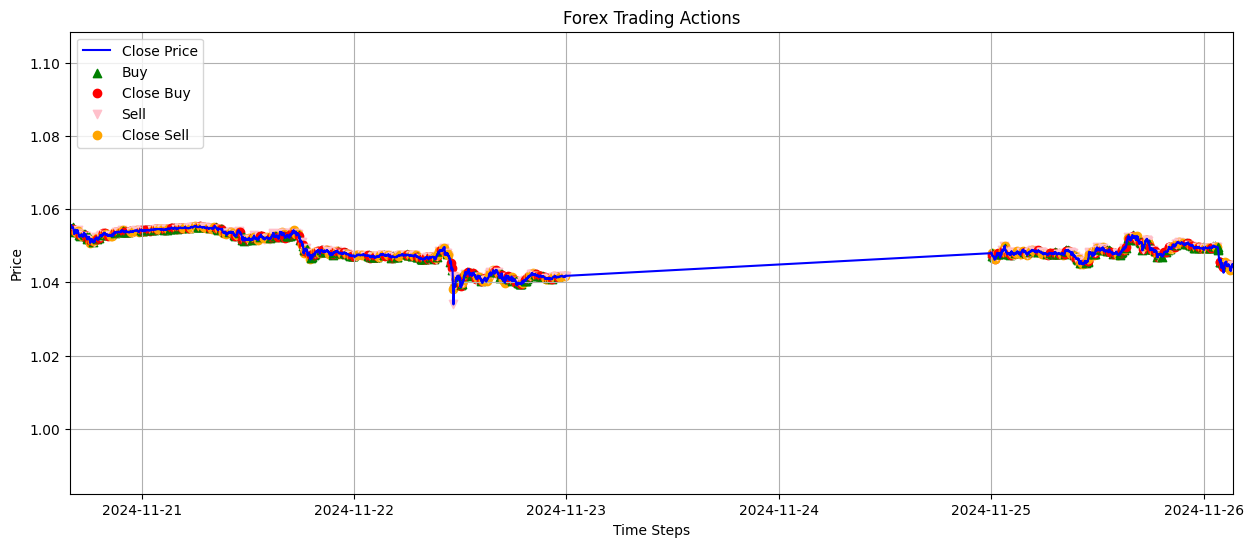

In [18]:
env = TRYForexEnv(df=df[:5000], window_size=12)
obs = env.reset()

while True:
    action, _states = best_model.predict(obs)
    
    obs, reward, done, info = env.step(action)
    
    if done:
        print("info", info)
        break
env.render()

env.plot_trades()

In [19]:
import MetaTrader5 as mt
import pandas as pd
from finta import TA
import time

mt.initialize()

# กำหนดค่าเริ่มต้น
symbol = "EURUSD"  # สัญลักษณ์ที่ต้องการเทรด
timeframe = mt.TIMEFRAME_H4  # กรอบเวลาของข้อมูล
window_size = 24  # จำนวนแท่งเทียนที่ต้องการดึง

# ฟังก์ชันดึงข้อมูลแท่งเทียนและเพิ่มฟีเจอร์
def get_candles_with_features(symbol, timeframe, window_size):
    rates = mt.copy_rates_from_pos(symbol, timeframe, 0, window_size)
    if rates is None or len(rates) < window_size:
        print("Failed to fetch data for", symbol)
        return None
    
    # แปลงข้อมูลเป็น DataFrame
    df = pd.DataFrame(rates)
    df['Datetime'] = pd.to_datetime(df['time'], unit='s')
    df = df.drop(columns=['time', 'real_volume'])  # ลบคอลัมน์ที่ไม่ต้องการ
    df.rename(columns={
        'close': 'Close',
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'tick_volume': 'Volume',
        'spread': 'Spread'
    }, inplace=True)
    df.set_index('Datetime', inplace=True)

    # เพิ่มฟีเจอร์ด้วย finta
    df['SMA'] = TA.SMA(df, 12)
    df['RSI'] = TA.RSI(df)
    df['OBV'] = TA.OBV(df)
    df.fillna(0, inplace=True)  # กรอกค่า NaN ด้วย 0
    
    return df

In [20]:
data = get_candles_with_features(symbol, timeframe, window_size)
print("Data with features 12:")
print(data[12:])

Data with features 12:
                        Open     High      Low    Close  Volume  Spread  \
Datetime                                                                  
2025-02-26 08:00:00  1.04912  1.05118  1.04871  1.04972   11223       1   
2025-02-26 12:00:00  1.04973  1.05022  1.04749  1.04842   12119       0   
2025-02-26 16:00:00  1.04840  1.05286  1.04791  1.04924   18786       0   
2025-02-26 20:00:00  1.04920  1.05003  1.04775  1.04823    9834       2   
2025-02-27 00:00:00  1.04767  1.04926  1.04727  1.04781    4395       2   
2025-02-27 04:00:00  1.04781  1.04805  1.04590  1.04651    6037       2   
2025-02-27 08:00:00  1.04647  1.04853  1.04638  1.04840   10962       1   
2025-02-27 12:00:00  1.04843  1.04898  1.04195  1.04233   14653       0   
2025-02-27 16:00:00  1.04232  1.04417  1.04001  1.04074   17699       0   
2025-02-27 20:00:00  1.04078  1.04178  1.03957  1.03963    7847       0   
2025-02-28 00:00:00  1.03927  1.04044  1.03843  1.03848    5821       2   
20

In [23]:
prediction, _ = best_model.predict(data[12:])
print("Prediction:", prediction.item())
execute_trade(2)

Prediction: 1
ปิดคำสั่ง Buy สำเร็จ, Volume: 0.1, Price: 1.03892
ปิดคำสั่ง Buy สำเร็จ, Volume: 0.1, Price: 1.03892
ปิดคำสั่ง Buy ล้มเหลว, Retcode: 10021, Error: (1, 'Success')
ปิดคำสั่ง Buy ล้มเหลว, Retcode: 10021, Error: (1, 'Success')
ปิดคำสั่ง Buy ล้มเหลว, Retcode: 10021, Error: (1, 'Success')
ปิดคำสั่ง Buy ล้มเหลว, Retcode: 10021, Error: (1, 'Success')
ปิดคำสั่ง Buy ล้มเหลว, Retcode: 10021, Error: (1, 'Success')
ปิดคำสั่ง Buy ล้มเหลว, Retcode: 10021, Error: (1, 'Success')
ปิดคำสั่ง Buy ล้มเหลว, Retcode: 10021, Error: (1, 'Success')
ปิดคำสั่ง Buy ล้มเหลว, Retcode: 10021, Error: (1, 'Success')
ปิดคำสั่ง Buy ล้มเหลว, Retcode: 10021, Error: (1, 'Success')


In [22]:
def execute_trade(action, volume=1.0):
    """
    ส่งคำสั่งซื้อขายจริงผ่าน MetaTrader 5 ตาม Action ที่ได้รับ:
    0 = Open Buy
    1 = Open Sell
    2 = Close Buy
    3 = Close Sell
    4 = Hold
    """
    price = mt.symbol_info_tick(symbol)
    if not price:
        print(f"ไม่พบข้อมูลราคา Symbol: {symbol}")
        return None

    # ตรวจสอบสถานะปัจจุบันของ position
    current_position = None
    positions = mt.positions_get(symbol=symbol)
    if positions:
        current_position = "buy" if positions[0].type == mt.ORDER_TYPE_BUY else "sell"
        current_volume = positions[0].volume
        entry_price = positions[0].price_open
    else:
        current_volume = 0
        entry_price = 0

    if action == 0:  # Open Buy
        if current_position is None:
            # เปิด buy ครั้งแรก
            request = {
                "action": mt.TRADE_ACTION_DEAL,
                "symbol": symbol,
                "volume": volume,
                "type": mt.ORDER_TYPE_BUY,
                "price": price.ask,
                "deviation": 10,
                "magic": 123456,
                "comment": "Open Buy Order",
                "type_time": mt.ORDER_TIME_GTC,
                "type_filling": mt.ORDER_FILLING_IOC,
            }
            result = mt.order_send(request)
            print(f"เปิด buy 1 volume, ที่ราคา {price.ask}")
        elif current_position == "buy":
            # เพิ่ม buy volume
            new_volume = current_volume + volume
            entry_price = ((entry_price * current_volume) + (price.ask * volume)) / new_volume
            request = {
                "action": mt.TRADE_ACTION_DEAL,
                "symbol": symbol,
                "volume": volume,
                "type": mt.ORDER_TYPE_BUY,
                "price": price.ask,
                "deviation": 10,
                "magic": 123456,
                "comment": "Add Buy Volume",
                "type_time": mt.ORDER_TIME_GTC,
                "type_filling": mt.ORDER_FILLING_IOC,
            }
            result = mt.order_send(request)
            print(f"ซื้อ buy เพิ่ม เป็น {new_volume} volume, ที่ราคา {price.ask}, เฉลี่ย = {entry_price}")
        else:
            print("ไม่สามารถเปิด buy ได้ เนื่องจากสถานะปัจจุบันเป็น sell")

    elif action == 1:  # Open Sell
        if current_position is None:
            # เปิด sell ครั้งแรก
            request = {
                "action": mt.TRADE_ACTION_DEAL,
                "symbol": symbol,
                "volume": volume,
                "type": mt.ORDER_TYPE_SELL,
                "price": price.bid,
                "deviation": 10,
                "magic": 123456,
                "comment": "Open Sell Order",
                "type_time": mt.ORDER_TIME_GTC,
                "type_filling": mt.ORDER_FILLING_IOC,
            }
            result = mt.order_send(request)
            print(f"เปิด sell 1 volume, ที่ราคา {price.bid}")
        elif current_position == "sell":
            # เพิ่ม sell volume
            new_volume = current_volume + volume
            entry_price = ((entry_price * current_volume) + (price.bid * volume)) / new_volume
            request = {
                "action": mt.TRADE_ACTION_DEAL,
                "symbol": symbol,
                "volume": volume,
                "type": mt.ORDER_TYPE_SELL,
                "price": price.bid,
                "deviation": 10,
                "magic": 123456,
                "comment": "Add Sell Volume",
                "type_time": mt.ORDER_TIME_GTC,
                "type_filling": mt.ORDER_FILLING_IOC,
            }
            result = mt.order_send(request)
            print(f"ซื้อ sell เพิ่ม เป็น {new_volume} volume, ที่ราคา {price.bid}, เฉลี่ย = {entry_price}")
        else:
            print("ไม่สามารถเปิด sell ได้ เนื่องจากสถานะปัจจุบันเป็น buy")

    elif action == 2:  # Close Buy
        if current_position == "buy":
            for pos in positions:
                if pos.type == mt.ORDER_TYPE_BUY:
                    request = {
                        "action": mt.TRADE_ACTION_DEAL,
                        "symbol": symbol,
                        "volume": pos.volume,
                        "type": mt.ORDER_TYPE_SELL,
                        "price": price.bid,
                        "deviation": 10,
                        "magic": 123456,
                        "comment": "Close Buy Position",
                        "type_time": mt.ORDER_TIME_GTC,
                        "type_filling": mt.ORDER_FILLING_IOC,
                        "position": pos.ticket,
                    }
                    result = mt.order_send(request)
                    if result.retcode == mt.TRADE_RETCODE_DONE:
                        print(f"ปิดคำสั่ง Buy สำเร็จ, Volume: {pos.volume}, Price: {price.bid}")
                    else:
                        print(f"ปิดคำสั่ง Buy ล้มเหลว, Retcode: {result.retcode}, Error: {mt.last_error()}")
        else:
            print("ไม่มีสถานะ Buy ที่จะปิดได้")

    elif action == 3:  # Close Sell
        if current_position == "sell":
            for pos in positions:
                if pos.type == mt.ORDER_TYPE_SELL:
                    request = {
                        "action": mt.TRADE_ACTION_DEAL,
                        "position": pos.ticket,
                        "symbol": symbol,
                        "volume": pos.volume,
                        "type": mt.ORDER_TYPE_BUY,
                        "price": price.ask,
                        "deviation": 10,
                        "magic": 123456,
                        "comment": "Close Sell Position",
                        "type_time": mt.ORDER_TIME_GTC,
                        "type_filling": mt.ORDER_FILLING_IOC,
                    }
                    result = mt.order_send(request)
                    print(f"ปิดคำสั่ง Sell, Volume: {pos.volume}, Price: {price.ask}, Result: {result.retcode}")
        else:
            print("ไม่มีสถานะ Sell ที่จะปิดได้")

    elif action == 4:  # Hold
        print("Hold: ไม่ทำการส่งคำสั่ง")


In [ ]:
# ตัวอย่างการใช้งาน
def main():
    while True:
        # ดึงข้อมูลพร้อมฟีเจอร์
        data = get_candles_with_features(symbol, timeframe, window_size)
        if data is None:
            time.sleep(300)  # รอ 5 นาทีหากดึงข้อมูลล้มเหลว
            continue

        print("Data with features 12:")
        print(data[12:])  # แสดงแท่งเทียนล่าสุด 5 แท่ง

        prediction, _ = best_model.predict(data[12:])
        print("Prediction:", prediction.item())
        execute_trade(prediction.item())
        time.sleep(300)

if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        print("Terminating program")

In [ ]:
import zmq

def main():
    # สร้าง ZeroMQ context
    context = zmq.Context()
    
    # สร้าง socket แบบ REP (Reply)
    socket = context.socket(zmq.REP)
    socket.bind("tcp://*:5555")  # ฟังที่พอร์ต 5555
    
    print("Python Server: Waiting for messages...")
    while True:
        # รับข้อความจาก MT5
        message = socket.recv()  # รับข้อมูลเป็นไบต์
        print(f"Received: {message.decode()}")  # แปลงข้อมูลเป็น string และพิมพ์ออกมา

        socket.send_string("Message received")
if __name__ == "__main__":
    main()

Python Server: Waiting for messages...
